Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image folder found at: /content/dataset/main_combined_dataset/images
Total images found: 24071


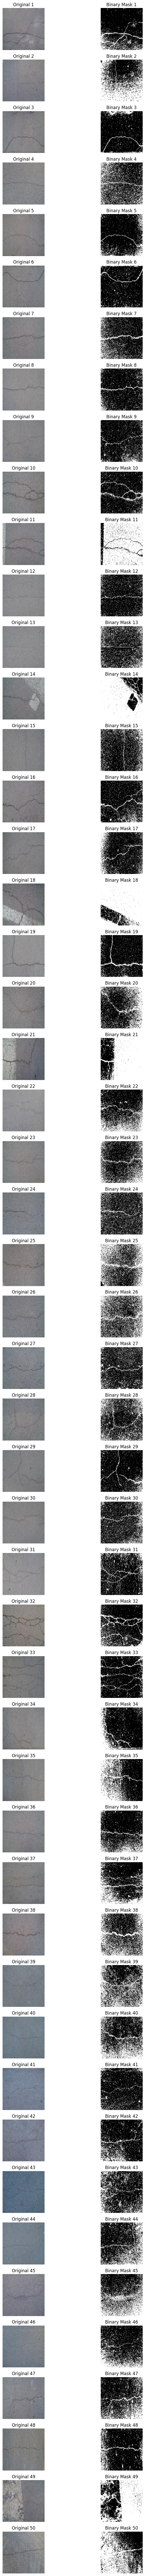

In [3]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Extract the ZIP file
import zipfile
import os

zip_path = '/content/drive/MyDrive/main_combined_dataset.zip'  # change if path is different
extract_path = '/content/dataset/'

# Extract only if not already done
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Step 3: Locate image folder
import glob

# Walk through folder to find the 'images' directory
def find_image_folder(base_path):
    for root, dirs, files in os.walk(base_path):
        if 'images' in root.lower():
            return root
    return None

image_folder = find_image_folder(extract_path)
print(f"Image folder found at: {image_folder}")

# Step 4: Load JPG/PNG images
image_files = sorted(glob.glob(os.path.join(image_folder, '*.jpg')) +
                     glob.glob(os.path.join(image_folder, '*.png')))

print(f"Total images found: {len(image_files)}")

# Use only a small batch for fast processing (change 50 as needed)
subset_image_files = image_files[:50]

# Step 5: Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Step 6: GMM Segmentation Function
def apply_gmm_binary_mask(image_path, k=2):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    pixels = gray.reshape(-1, 1)
    scaler = StandardScaler()
    pixels_scaled = scaler.fit_transform(pixels)

    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(pixels_scaled)
    labels_image = labels.reshape(gray.shape)

    # Lower intensity = crack
    class_means = [pixels[labels == i].mean() for i in range(k)]
    crack_class = np.argmin(class_means)

    binary_mask = (labels_image == crack_class).astype(np.uint8) * 255
    return image_rgb, binary_mask

# Step 7: Visualize Results
fig, axes = plt.subplots(len(subset_image_files), 2, figsize=(10, len(subset_image_files) * 2))
for idx, image_path in enumerate(subset_image_files):
    try:
        original_img, crack_mask = apply_gmm_binary_mask(image_path)
        axes[idx, 0].imshow(original_img)
        axes[idx, 0].set_title(f"Original {idx+1}")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(crack_mask, cmap='gray')
        axes[idx, 1].set_title(f"Binary Mask {idx+1}")
        axes[idx, 1].axis('off')
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()
